In [3]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, GlobalMaxPool1D, Dropout, Dense,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import spacy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

Чтение данных и разделение на обучающие и тестовые

In [ ]:
train = pd.read_csv('train.csv')
X_train, X_test, Y_train, Y_test = train_test_split(
    train["comment_text"],
    train.drop(['id', 'comment_text'], axis=1),
    test_size=0.15,
    random_state=5
)

Добавим еще один признак в исходные данные – количество слов в тексте

In [ ]:
def count_words(text):
    words = re.findall(r'\b\w+\b', text)
    return len(words)
train['len']=train["comment_text"].apply(count_words)

In [ ]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,len
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,69.176812
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,102.199498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,77.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1403.000000


(array([1.41201e+05, 1.26520e+04, 2.79700e+03, 1.14700e+03, 8.40000e+02,
        7.01000e+02, 1.83000e+02, 3.40000e+01, 1.20000e+01, 4.00000e+00]),
 array([1.0000e+00, 1.4120e+02, 2.8140e+02, 4.2160e+02, 5.6180e+02,
        7.0200e+02, 8.4220e+02, 9.8240e+02, 1.1226e+03, 1.2628e+03,
        1.4030e+03]),
 <BarContainer object of 10 artists>)

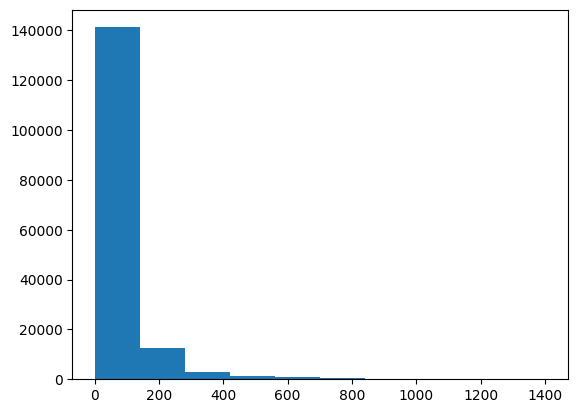

In [ ]:
plt.hist(train['len'])

In [6]:
b=len(train.loc[train['len'] < 320, 'len'])
print(b)

155019


In [ ]:
MAX_FEATURES = 200000
maxlen = 320
embed_size = 128

Лемматизация

In [ ]:
en = spacy.load('en_core_web_sm')
def lemmatize(text):
    a = en(text)
    return ' '.join([token.lemma_ for token in a])

tqdm.pandas()
X_train = X_train.progress_apply(lemmatize)
X_test = X_test.progress_apply(lemmatize)

  0%|          | 0/135635 [00:00<?, ?it/s]

  0%|          | 0/23936 [00:00<?, ?it/s]

In [ ]:
#lemtrain= pd.read_csv("/content/drive/My Drive/Colab Notebooks/train_lem.csv")
#lemtest= pd.read_csv("/content/drive/My Drive/Colab Notebooks/test_lem.csv")
#X_train = lemtrain["comment_text"]
#Y_train=lemtrain.drop(['comment_text'], axis=1)
#X_test = lemtest["comment_text"]
#Y_test=lemtest.drop([ 'comment_text'], axis=1)

Векторизация текстов

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=maxlen,
                               output_mode='int')
vectorizer.adapt(X_train.values)

vectorized_train_text = vectorizer(X_train.values)
vectorized_test_text = vectorizer(X_test.values)

LSTM

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(MAX_FEATURES, embed_size)(inp)
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 3
history = model.fit(
    vectorized_train_text, Y_train,
    batch_size=batch_size,
    epochs=epochs
)
test_loss,test_acc=model.evaluate(vectorized_test_text,Y_test)

Epoch 1/3
4239/4239 [==============================] - 143s 33ms/step - loss: 0.0631 - accuracy: 0.9430
Epoch 2/3
4239/4239 [==============================] - 90s 21ms/step - loss: 0.0411 - accuracy: 0.9907
Epoch 3/3
748/748 [==============================] - 6s 7ms/step - loss: 0.0482 - accuracy: 0.9942


CNN

In [ ]:
inp1 = Input(shape=(maxlen,))
x1 = Embedding(MAX_FEATURES, embed_size)(inp1)
x1 = Conv1D(filters=128, kernel_size=5, activation='relu')(x1)
x1 = GlobalMaxPool1D()(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(50, activation='relu')(x1)
x1 = Dense(6, activation='sigmoid')(x1)

model1 = Model(inputs=inp1, outputs=x1)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 3
history = model1.fit(
    vectorized_train_text, Y_train,
    batch_size=batch_size,
    epochs=epochs
)
test_loss,test_acc=model1.evaluate(vectorized_test_text,Y_test)

Epoch 1/3
4239/4239 [==============================] - 104s 24ms/step - loss: 0.0640 - accuracy: 0.9683
Epoch 2/3
4239/4239 [==============================] - 50s 12ms/step - loss: 0.0456 - accuracy: 0.9902
Epoch 3/3
748/748 [==============================] - 2s 2ms/step - loss: 0.0471 - accuracy: 0.9916


In [7]:
#train_combined = pd.concat([X_train.reset_index(drop=True), Y_train.reset_index(drop=True)], axis=1)
#train_combined.head(20)

In [ ]:
#train_combined.to_csv("/content/drive/My Drive/Colab Notebooks/train_lem.csv", index=False)

In [ ]:
#test_combined = pd.concat([X_test.reset_index(drop=True), Y_test.reset_index(drop=True)], axis=1)
#test_combined.to_csv("/content/drive/My Drive/Colab Notebooks/test_lem.csv", index=False)

Bidirectional LSTM

In [ ]:
inp2 = Input(shape=(maxlen,))
x2 = Embedding(MAX_FEATURES, embed_size)(inp2)
x2 = Bidirectional(LSTM(60, return_sequences=True))(x2)
x2 = GlobalMaxPool1D()(x2)
x2 = Dropout(0.5)(x2)
x2 = Dense(50, activation='relu')(x2)
#x2 = Dropout(0.5)(x2)
x2 = Dense(6, activation='sigmoid')(x2)

model2 = Model(inputs=inp2, outputs=x2)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
batch_size = 32
epochs = 3
history = model2.fit(
    vectorized_train_text, Y_train,
    batch_size=batch_size,
    epochs=epochs
)
test_loss,test_acc=model2.evaluate(vectorized_test_text,Y_test)

Epoch 1/3
4239/4239 [==============================] - 187s 42ms/step - loss: 0.0658 - accuracy: 0.9629
Epoch 2/3
4239/4239 [==============================] - 130s 31ms/step - loss: 0.0424 - accuracy: 0.9922
Epoch 3/3
748/748 [==============================] - 9s 11ms/step - loss: 0.0461 - accuracy: 0.9937
